# This is a tutorial on setting the Jupyter environment with Postgres ;)


In [41]:
import tensorflow as tf
import numpy as np
import psycopg2  as pg
import pprint  
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


We'll use sqlalchemy's create_engine to create a connection between the jupyter notebook and the postgres database. Replace configuration with your own. 

In [15]:
from sqlalchemy import create_engine

#configuration
database_name="postgres"
adress = 'localhost' 
port = '5432'
username = 'postgres' 
password = 'kretenbudala546' 

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
 .format(username=username,
              password=password,
              ipaddress=adress,
              port=port,
              dbname=database_name))

# Create the connection
cnx = create_engine(postgres_str)
print("Connected to database! ")

Connected to database! 


We'll convert the data into a pandas dataframe, so it can be processed! 

In [31]:
# Make sure you use the semicolon at the end as this is still postgres. 
query = 'select * from passengers;'
df=pd.read_sql_query(query, cnx)
df.head()

,id,survived,pclass,name,sex,age,siblings_spouses,parents_children,fare
0,1,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,2,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,3,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,4,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,5,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [20]:
df.shape

(887, 9)

In [21]:
df.dtypes

id                    int64
survived              int64
pclass                int64
name                 object
sex                  object
age                 float64
siblings_spouses      int64
parents_children      int64
fare                float64
dtype: object

Trying to figure out if passenger class and sex had anything to do with the survival rate. 

In [33]:
df[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().sort_values(by='survived',ascending=False)

,pclass,survived
0,1,0.629630
1,2,0.472826
2,3,0.244353


Suggests that people on the first class were more likely to survive on Titanic. 

In [34]:
df[['sex', 'survived']].groupby(['sex'], as_index=False).mean().sort_values(by='survived',ascending=False)

,sex,survived
0,female,0.742038
1,male,0.190227


In [35]:
df[['siblings_spouses', 'survived']].groupby(['siblings_spouses'], as_index=False).mean().sort_values(by='survived',ascending=False)

,siblings_spouses,survived
1,1,0.535885
2,2,0.464286
0,0,0.347682
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


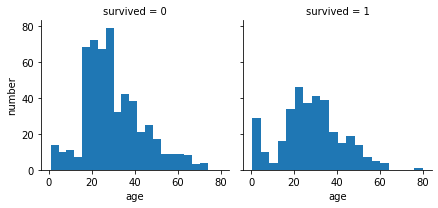

In [42]:
age_hist = sns.FacetGrid(df, col='survived')
age_hist.map(plt.hist, 'age', bins=20)
age_hist.set_ylabels('number')

/home/tim/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


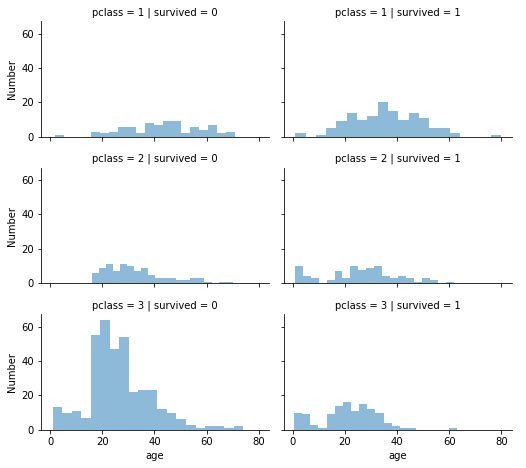

In [87]:
pclass_age_grid = sns.FacetGrid(df, col='survived', row='pclass', size=2.2, aspect=1.6)
pclass_age_grid.map(plt.hist, 'age', alpha=0.5, bins=20)
pclass_age_grid.add_legend()
pclass_age_grid.set_ylabels('Number')

In [90]:
#sex to binary of 0 and 1
#df['gender_factor'] = pd.factorize(df.sex)[0]
df.drop(['name'],axis=1,inplace=True)
df.head()

,id,survived,pclass,age,siblings_spouses,parents_children,fare,gender_factor
0,1,0,3,22.0,1,0,7.2500,0
1,2,1,1,38.0,1,0,71.2833,1
2,3,1,3,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,0,3,35.0,0,0,8.0500,0


In [91]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

percentage =test.shape[0]/df.shape[0]
print("Percentage of test data:",percentage )

Train shape:  (709, 8)
Test shape:  (178, 8)
Percentage of test data: 0.20067643742953778


In [92]:
X_train = train.drop("survived", axis=1)
Y_train = train['survived']
X_test = test.drop('id', axis=1).copy()

In [93]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
accuracy = round(knn.score(X_train, Y_train) *100, 2)
accuracy

74.33

In [98]:
submission =pd.DataFrame({
    "PassengerId":test['id'],
    "Survived": Y_pred
})
submission.to_csv("submission.csv", index=False)